dict_keys(['__header__', '__version__', '__globals__', 'DN1213', 'UsiDR1213', 'VsiDR1213', 'SSCsiDR1213', 'DN1314', 'UsiDR1314', 'VsiDR1314', 'SSCsiDR1314', 'HlDR', 'UsiUR1213', 'VsiUR1213', 'SSCsiUR1213', 'UsiUR1314', 'VsiUR1314', 'SSCsiUR1314', 'HlUR', 'ZsiDR1213', 'ZsiDR1314', 'ZsiUR1213', 'ZsiUR1314'])
{'DN': array([735537.75694444, 735537.77777778, 735537.79861111, ...,
       735670.65277778, 735670.67361111, 735670.69444444], shape=(6382,)), 'U': array([[       nan,        nan,        nan, ..., 0.18880918, 0.1543357 ,
        0.0084192 ],
       [       nan,        nan,        nan, ..., 0.26080063, 0.22267992,
        0.08658393],
       [       nan,        nan,        nan, ..., 0.29408892, 0.25430058,
        0.12322081],
       ...,
       [       nan,        nan,        nan, ..., 0.17674281, 0.14016012,
        0.10230979],
       [       nan,        nan,        nan, ..., 0.14649478, 0.12249576,
        0.07637945],
       [       nan,        nan,        nan, ..., 0.13036249,

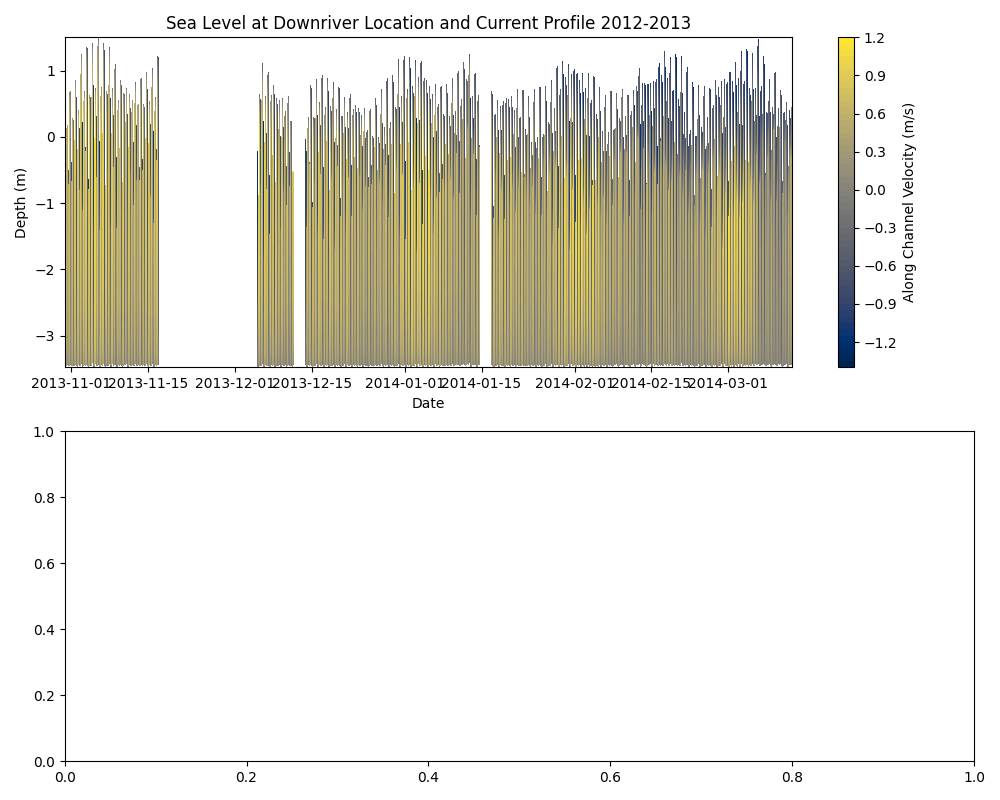

SyntaxError: 'break' outside loop (3959436770.py, line 123)

In [ ]:
# private dock midestuary
# Data points every 5 minuetes
# HDR is sea level

import pandas as pd
import scipy.io as sio
from scipy import interpolate
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
%matplotlib ipympl

def Array_To_DataFrame(matDF, varName) :
    npArray = np.array([])
    for i in range (matDF[varName].shape[0]) :
        npArray = np.concatenate((npArray, matDF[varName][i].flatten()))
    return npArray
def matFile_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {}
    for dictKey in tempDF.keys() :
        if isinstance(tempDF[dictKey], np.ndarray) :
            if tempDF[dictKey].shape[0] > 1 :
                matDataMidFiltered.update({dictKey : tempDF[dictKey]})

    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    return matMidDF

def matFileCurrent_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {}
    for dictKey in tempDF.keys() :
        if isinstance(tempDF[dictKey], np.ndarray) :
            if tempDF[dictKey].shape[0] > 1 and tempDF[dictKey].shape[1] > 1 :
                for i in range(tempDF[dictKey].shape[0]) :
                    matDataMidFiltered.update({dictKey + '_z_' + str(i) : tempDF[dictKey][i]})
            elif dictKey == 'DN':
                matDataMidFiltered.update({dictKey : tempDF[dictKey]})

    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    matMidZ = pd.DataFrame({'z' : tempDF['Z'].flatten()})
    return (matMidDF, matMidZ, tempDF)

# import files for 2012-2013 and extract sea level data
matDockDF = matFile_To_DF('2013_14\\P_processed_01.mat')
# import downriver current data
mainFile = sio.loadmat('Processing Files\\UV_SSC_extrap.mat')
print(mainFile.keys())
downriver = mainFile['DN1314']
alongChannelVelocity = mainFile['UsiDR1314']
depths = mainFile['ZsiDR1314']
seaLevel = mainFile['HlDR']
ADCPDict = {'DN' : downriver.flatten(), 'U' : alongChannelVelocity, 'Z' : depths, 'H' : seaLevel.flatten()}
print(ADCPDict)
# import upriver current data
print(len(matDockDF['DN']), len(ADCPDict['DN']), len(ADCPDict['U']), len(ADCPDict['Z']), len(ADCPDict['H']))
ADCPDictUResized = np.resize(ADCPDict['U'], (ADCPDict['U'].shape[0], 38311))
for i in range(ADCPDict['U'].shape[0]) :
    #print(AquadoppDict['U'][i])
    #print(AquadoppDict['DN'])
    #print(np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i]))
    tempNp = np.interp(matDockDF['DN'], ADCPDict['DN'].flatten(), ADCPDict['U'][i])
    ADCPDictUResized[i] = tempNp

original_time = np.linspace(0, 1, ADCPDict['Z'].shape[1])  # shape (6382,)
target_time = np.linspace(0, 1, ADCPDictUResized.shape[1])  # shape (38311,)

# Interpolate each depth row
Z_interpolated = np.array([
    np.interp(target_time, original_time, ADCPDict['Z'][i])
    for i in range(ADCPDict['Z'].shape[0])
])



origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')
ADCPDict['DN'] = (ADCPDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
matDockDF['DN'] = (matDockDF['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
seaLevelfig = px.line(x = matDockDF['DN'], y = [matDockDF['Hdr']], color_discrete_sequence= ["blue"], title = "Sea Level")
seaLevelFigLabel = ['Downriver Sea Level']
for idx in range(len(seaLevelFigLabel)):
    seaLevelfig.data[idx].name = seaLevelFigLabel[idx]
    seaLevelfig.data[idx].hovertemplate = 'variable=' + seaLevelFigLabel[idx] + '<br>x=%{x}<br>value=%{y}<extra></extra>'
    seaLevelfig.data[idx].legendgroup = seaLevelFigLabel[idx]

seaLevelfig.update_layout(title=dict(text= "Sea Level for 2013-2014", font=dict(size=25)))
seaLevelfig.update_xaxes(tickangle=30)
seaLevelfig.update_xaxes(rangeslider_visible=True)
seaLevelfig.update_xaxes(range = [pd.Timestamp('2013-10-28'),pd.Timestamp('2014-03-17')])
seaLevelfig.update_layout(xaxis_title="Date", yaxis_title="Sea Level (m)", legend_title="Locations")
#seaLevelfig.show()

print("DN:", matDockDF['DN'].shape)
print("Z:", ADCPDict['Z'].shape)
print("U:", ADCPDictUResized.shape)


fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plt.subplots_adjust(hspace=3)

# Create 2D meshgrid for time
#shape (20, 38311)
# you need to bin the data (for depth axis since you have same depth values repeated) 
# Replace row indices with actual depth values from Z
Y = Z_interpolated  # shape (20, 38311)

# Now plot
#USE PCOLOR
fig.colorbar(contourPlot, ax = ax1, label = 'Along Channel Velocity (m/s)')
#ax1.plot(matDockDF['DN'], matDockDF['Hdr'], linewidth=2, label='SeaLevel at Downriver Location', color = 'black')
ax1.set_title('Sea Level at Downriver Location and Current Profile 2012-2013')
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (m)')
plt.tight_layout()
plt.show()


break 
#(matADCPDF, matADCPZDF, ADCPDict, matAquadoppDF, matAquadoppZDF, AquadoppDict) = matFileCurrent_To_DF('Processing Files\\UV_SSC_extrap.mat')
#mat lab date origin
#print(ADCPDict['Z'])
ADCPDictUResized = np.resize(ADCPDict['U'], (ADCPDict['U'].shape[0], 46099))
AquadoppDictUResized = np.resize(AquadoppDict['U'], (AquadoppDict['U'].shape[0], 46099))

for i in range(ADCPDict['U'].shape[0]) :
    #print(AquadoppDict['U'][i])
    #print(AquadoppDict['DN'])
    #print(np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i]))
    tempNp = np.interp(matDockDF['DN'], ADCPDict['DN'].flatten(), ADCPDict['U'][i])
    ADCPDictUResized[i] = tempNp

for i in range(AquadoppDict['U'].shape[0]) :
    #print(AquadoppDict['U'][i])
    #print(AquadoppDict['DN'])
    #print(np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i]))
    tempNp = np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i])
    AquadoppDictUResized[i] = tempNp

#mat lab date origin
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')

#convert DN to datetime
matDockDF['DN'] = (matDockDF['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
ADCPDict['DN'] = (ADCPDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
AquadoppDict['DN'] = (AquadoppDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')


# testing heat maps / plotting under the curve
'''
# Align and interpolate U to match dock time series
plt.cla()
plt.contourf(matDockDF['DN'], (matADCPZDF['z'] + 0.4367), ADCPDictUResized, levels = 15, cmap = 'cividis')
plt.colorbar(label = 'Along Channel Velocity (m/s)')
plt.plot(matDockDF['DN'], matDockDF['Hdr'], linewidth=2, label='SeaLevel at Downriver Location', color = 'black')
plt.title('Sea Level at Downriver Location and Current Profile 2012-2013')
plt.xlabel('Date')
plt.ylabel('Depth (m)')
plt.show()
'''
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plt.subplots_adjust(hspace=3)
contourPlot = ax1.contourf(matDockDF['DN'], (matADCPZDF['z'] + 0.4367), ADCPDictUResized, levels = len(matADCPZDF['z']), cmap = 'cividis')
fig.colorbar(contourPlot, ax = ax1, label = 'Along Channel Velocity (m/s)')
ax1.plot(matDockDF['DN'], matDockDF['Hdr'], linewidth=2, label='SeaLevel at Downriver Location', color = 'black')
ax1.set_title('Sea Level at Downriver Location and Current Profile 2012-2013')
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (m)')

contourPlot2 = ax2.contourf(matDockDF['DN'], (matAquadoppZDF['z'] + 0.4100), AquadoppDictUResized, levels = len(matAquadoppZDF['z']), cmap = 'cividis')
fig.colorbar(contourPlot2, ax = ax2, label = 'Along Channel Velocity (m/s)')
ax2.plot(matDockDF['DN'], matDockDF['Hur'], linewidth=2, label='SeaLevel at Upriver Location', color = 'black')
ax2.set_title('Sea Level at Upriver Location and Current Profile 2012-2013')
ax2.set_xlabel('Date')
ax2.set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()
'''
figHm = go.Figure(data = go.Heatmap(z=ADCPDictUResized, x=matDockDF['DN'], y=(matADCPZDF['z'] + 0.4367), colorscale='cividis', colorbar=dict(title="Along Channel Velocity (m/s)"), zsmooth = 'best'))
#figHm = go.Figure(data = go.Contour(z=ADCPDictUResized, x= matDockDF['DN'], y = (matADCPZDF['z'] + 0.4367), colorscale='cividis', colorbar=dict(title="Along Channel Velocity (m/s"), ncontours = 5))
figHm.add_trace(go.Scatter(x = matDockDF['DN'], y = matDockDF['Hdr'], mode = 'lines', name = 'Downriver Sea Level', line=dict(color='black')))
figHm.update_layout(title_text="Sea Level at Downriver Location and Current Profile 2013-2014")
figHm.update_xaxes(range=["2012-12-11", "2012-12-14"])
figHm.update_layout(xaxis_title = "Date", yaxis_title = "Depth (m)")
figHm.show()
'''
'''
figHm2 = go.Figure(data = go.Heatmap(z=AquadoppDictUResized, x=matDockDF['DN'], y=(matAquadoppZDF['z'] + 0.4100), colorscale='cividis', colorbar=dict(title="Along Channel Velocity (m/s)"), zsmooth = 'best'))
#figHm2 = go.Figure(data = go.Contour(z=AquadoppDictUResized))
figHm2.add_trace(go.Scatter(x = matDockDF['DN'], y = matDockDF['Hur'], mode = 'lines', name = 'Upriver Sea Level', line=dict(color = 'black')))
figHm2.update_layout(title_text="Sea Level at Upriver Location and Current Profile 2013-2014")
figHm2.update_layout(xaxis_title = "Date", yaxis_title = "Depth (m)")
figHm2.show()   '''